# 1. 모델 구조와 작동 과정
## 모델 구조
결정 나무는 이름에서 알 수 있듯이 그 구조가 나무 구조(tree-structured)인 분류 및 회귀 모델 입니다.
- 잎 노드를 제외한 모든 노드는 가지(branch)를 통해 두 개의 노드로 분지됨
- 각 가지에는 노드를 분리하는 조건이 있고 각 노드에는 해당 조건을 만족하는 학습 샘플이 포함됨
- 더 이상 분지되지 않는 최하위 노드인 잎 노드에 속한 학습 샘플을 바탕으로 라벨에 대한 예측을 수행함

# 2. 모델 특성
## 수직/수평 공간 분할
결정 나무는 데이터 공간을 수직이나 수평으로만 분할하는 특성이 있습니다.
- 각 가지에 부여된 조건의 구조가 특징 x랑 상수 c를 비교하는 x<c 의 구조이기 때문
- 결정 나무는 데이터 공간을 비선형적으로 분리할 수 없어, 기존 특징을 변환하거나 새로운 특징을 생성해야 함

## 높은 설명력
결정 나무는 모델의 작동 과정을 IF - THEN 규칙 집합 형태로 손쉽게 설명할 수 있으며, 규칙의 근거 샘플 수와 정확도도 알 수 있습니다.
- 이러한 설명력 덕분에 결정 나무는 대출 연체 여부 예측 등 설명력이 필요한 과제에 많이 사용함
- 심지어는 지도 학습 과제가 아니라 특정한 이벤트의 발생 조건을 판단하는 데도 사용함

## 이진화
결정 나무는 모든 종류의 특징을 이진화 합니다.
- 연속형 특징 x에 대해서도 c보다 작거나 같은 지만 판단하므로, x를 사용한 것과 x<c 인지를 나타내는 이진형 특징을 사용한 것과 같은 효과를 냄
- 연속형 특징이 가진 정보가 거의 무시된다는 문제가 있음
- 특징이 모두 이진화 되기 때문에 다른 모델에 비해 전처리가 가장 적게 필요함
  - 스케일링 전에는 x<c라는 조건이 스케일링 후에는 x' < c' 로 스케일만 바뀌므로 스케일링할 필요가 없음
  - 더미화를 하지 않더라도 x == c라는 형태의 조건을 통해 더미화를 한 것처럼 모델이 작동함
  - 결측을 따로 대체하지 않더라도 결측 자체를 값으로 간주하여 x == nan 이라는 형태의 질문을 만들 수도 있습니다.

# 3. 주요 하이퍼 파라미터
## 깊이
깊이가 깊어질수록 가지가 더 많아 데이터 공간이 더 잘게 쪼개지므로, 깊이와 복잡도는 정비례한다고 할 수 있습니다.
- 결정 나무의 모델 복잡도는 깊이로 결정된다고 하더라도 과언이 아님
- 사이킷런에는 max_depth, min_samples_leaf, min_impurity_decrease 등 복잡도와 관련된 다양한 하이퍼 파라미터가 있으나 모두 깊이를 결정하기 위한 것임

## 클래스 가중치
클래스 가중치를 설정함으로써 비용 민감 모델로 변환할 수 있음

$\hat{y}=
\begin{cases}
1,\;if\;w_1n_1>w_0n_0\\
0,\;\;\,otherwise
\end{cases}$

- $w_1$ : $n_1$에 대한 가중치 (보통 클래스 불균형 비율로 설정)
- $w_0$ : $n_0$에 대한 가중치 (보통 1로 설정)

## 분지 기준
분기 기준에 따른 모델의 성능은 큰 차이가 없다고 알려져 있습니다.
- 결정 나무의 학습은 각 노드의 불순도(impurity)를 최소화하는 조건을 찾아 노드를 분지하는 것이라 할 수 있음
- 불순도란 각 노드에 속한 라벨의 편차라고 할 수 있음
  - (분류) 라벨이 한 클래스의 값을 주로 가질 때 불순도가 낮음
  - (회귀) 라벨의 표준편차가 작을 때 불순도가 낮음
- 불순도를 측정하는 척도로 엔트로피와 지니 지수 등이 있으니, 측정 방법에 따른 모델의 성능은 큰 차이가 없다고 알려져 있음
  - 대표적인 하이퍼 파라미터지만 측정 방법에 따른 성능 차이가 크지 않아 하이퍼 파라미터 튜닝 대상에 포함할 필요가 없음

# 4. 사이킷런 실습
## 예제 데이터 불러오기
결정 나무를 학습할 예제 데이터를 불어 옵니다.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('../data/classification/glass6.csv')
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022)

## 모델 학습
결정 나무는 tree 모듈의 DecisionTreeClassifier와 DecisionTreeRegressor 클래스를 이용해 구현할 수 있습니다.

주요 인자
- max_depth
  - 최대 깊이
  - 기본값 : None
    - 기본값으로 설정되면 잎 노드에 min_samples_split보다 작은 샘플 수가 포함될 때까지 분지하여 최대 깊이까지 학습합니다.
- min_samples_split
  - 노드를 분지할 수 있는 노드 내 최소 샘플 수
  - 기본값: 2
- class_weight
  - 클래스 가중치로 키가 클래스 값이 가중치인 사전
  - 기본값 : None
    - 기본값으로 설정되면 각 클래스에 대한 가중치를 모두 1로 설정합니다.

결정 나무 모델 학습 예제

In [2]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import *
model = DTC(random_state=2022).fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print(acc, rec)

0.8888888888888888 0.5454545454545454


- 라인3 : 결정 나무를 분지할 때 모든 조건을 탐색하지 않고 임의로 일부만 탐색하므로 실행시마다 결과가 달라질 수 있습니다. 이를 방지하기 위해서 씨드를 고정했습니다.

## 전처리의 불필요 확인
앞서 설명한대로 스케일링할 필요가 없는지를 확인해보겠습니다.

전처리의 불필요성 확인 예제

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
Z_train = scaler.transform(X_train)
Z_test = scaler.transform(X_test)
model2 = DTC(random_state=2022).fit(Z_train, y_train)
y_pred = model2.predict(Z_test)
acc = accuracy_score(y_test,y_pred)
rec = recall_score(y_test,y_pred)
print(acc,rec)

0.8888888888888888 0.5454545454545454


## 클래스 가중치 설정
클래스 가중치를 설정해서 비용 민감 모델을 학습하겠습니다

클래스 불균형 비율 계산 예제

In [5]:
num_majority_sample = y_train.value_counts().iloc[0]
num_minority_sample = y_train.value_counts().iloc[-1]
class_imbalance_ratio = num_majority_sample / num_minority_sample
print(class_imbalance_ratio)

8.352941176470589


- 라인 1
  - value_counts 메서드를 이용해 다수 클래스 샘플 수를 계산합니다. 
  - value_counts 메서드는 시리즈 요소의 출현 빈도를 내림차순으로 정렬하므로 0번째에 나오는 값이 다수 클래스의 샘풀 수가 됩니다.
  

- 라인 2
  - 라인 1과 비슷한 방법으로 소수 클래스 샘플 수를 계산 했습니다.

- 라인 3
  - 다수 클래스 샘플 수를 소수 클래스 샘플 수로 나눠 클래스 불균형 비율을 계산

클래스 가중치 적용 예제

In [6]:
model3 = DTC(random_state=2022, class_weight={0:1,1:class_imbalance_ratio}).fit(X_train, y_train)
y_pred = model3.predict(X_test)
acc = accuracy_score(y_test,y_pred)
rec = recall_score(y_test,y_pred)
print(acc, rec)

0.8888888888888888 0.5454545454545454


- 라인 1
  - 클래스 0의 가중치를 1로, 클래스 1의 가중치를 class_imbalance_ratio로 설정


- 성능에 전혀 변화가 없음
- 가중치를 더 크게 부여해야 함

클래스 가중치를 설정해서 비용 민감 모델을 학습하겠습니다.

클래스 가중치 적용 예제

In [7]:
model4 = DTC(class_weight={0:1,1:class_imbalance_ratio*100}).fit(X_train, y_train)
y_pred = model4.predict(X_test)
acc = accuracy_score(y_test,y_pred)
rec = recall_score(y_test,y_pred)
print(acc, rec)

0.9259259259259259 0.6363636363636364


- 재현율과 정확도가 모두 올랐음
- 이는 소수 클래스의 결정 공간이 확장할 때 주로 발생하는 다수 클래스의 오 뷴류가 발생하지 않았기 때문
- 그러나 일반적으로는 소수 클래스에 대한 가중치를 크게 설정할수록 정확도는 떨어지고 재현율은 올라감

## 모델 해석 : export_text 함수
export_text 함수는 학습한 결정 나무의 구조를 문자열로 시각화 합니다.

주요 인자
- decision_tree
    - 학습된 결정 나무
- feature_names
    - 결정 나무 학습 당시 사용했던 특징 이름 리스트

export_text 함수 사용 예시

In [8]:
from sklearn.tree import export_text
r = export_text(model, feature_names=list(X_train.columns))
print(r)

|--- x8 <= 0.40
|   |--- x5 <= 74.86
|   |   |--- class: 0
|   |--- x5 >  74.86
|   |   |--- x6 <= 1.35
|   |   |   |--- class: 0
|   |   |--- x6 >  1.35
|   |   |   |--- class: 1
|--- x8 >  0.40
|   |--- x3 <= 2.26
|   |   |--- class: 1
|   |--- x3 >  2.26
|   |   |--- class: 0



x8 <= 0.40 이고 x5 <= 74.86 이면 클래스를 0으로 분류하고,

x8 <= 0.40 이고 x5 > 74.86 이고 x6 > 1.35 라면 클래스를 1로 분류

## 모델 해석 : plot_tree 함수
plot_tree 함수는 학습한 결정 나무의 구조를 그래프로 시각화 합니다.

주요 인자
- decision_tree
    - 학습된 결정 나무
- feature_names
    - 결정 나무 학습 당시 사용했던 특징 이름 리스트
- class_names
    - 결정 나무 학습 당시 사용했떤 클래스 이름 리스트

plot_tree 함수 사용 예시

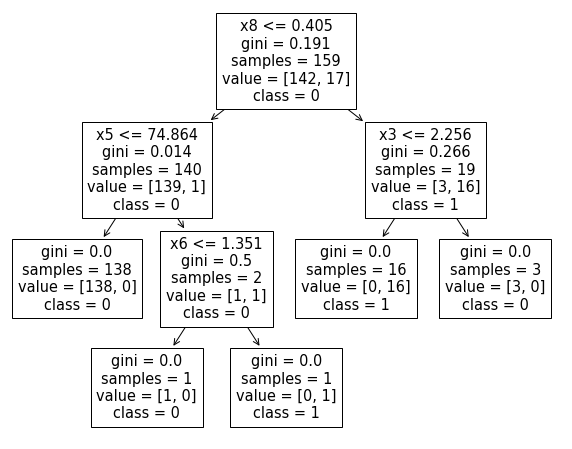

In [9]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
plot_tree(model, feature_names=list(X_train.columns), class_names=["0","1"])
plt.show()

- 라인 2 – 3
    -matplotlib의pyplot을이용해그래프의 크기를 (10, 8)로설정했습니다.
    - 그래프 크기를 설정하지 않으면 시각화한 결정 나무의노드가 서로 겹치는 현상이 발생할 수 있습니다. 


사각형은 노드를 나타내며, 노드 안에 있는 값은 순서대로 규칙, 지니 계수, 해당 노드에 속하는 샘플 수, 각 클래스에 속하는 샘플 수, 예측값

(예시) 가장 왼쪽에 있는 노드는 샘플이 138개가있으며, 이 가운데 클래스 0에속하는 샘플은 138개, 1에속하는 샘플은 0개이므로 클래스0으로 예측하는노드

## 모델 해석 심화 : 규칙 추출
깊이가 깊을수록 그래프를 이용한 시각화 결과를 해석하기 어려워, 결정 나무를 규칙 집합 형태로 변환하는 것이 필요합니다.

In [10]:
def text_to_rule_list(r):
    node_list = []
    leaf_node_list = []

    for i, node in enumerate(r.split("\n")[:-1]):
        rule = node.split('- ')[1]
        indent = node.count(' ' * 3)
        if 'class' in rule:
            leaf_node_list.append([i, rule, indent])

        node_list.append([i, rule, indent])

    prediction_rule_list = []
    for leaf_node in leaf_node_list:
        prediction_rule = []
        idx, decision, indent = leaf_node
        for indent_level in range(indent-1, -1, -1):
            for node_idx in range(idx, -1, -1):
                node = node_list[node_idx]
                rule = node[1]
                if node[2] == indent_level and "class" not in node[1]:
                    prediction_rule.append(rule)
                    break
        prediction_rule_list.append([prediction_rule, decision])

    return prediction_rule_list

- 라인 2 – 3
    - r을구성하는 노드 목록 node_list를초기화합니다.
    - 잎노드를 기준으로규칙을 추출하기 위해 잎노드 목록 leaf_node_list도따로 정의합니다.
- 라인 5
    - r을줄 바꿈 기호로 나눈 뒤 i는 인덱스를 node로값을 순회합니다.
    - 예를 들어, 처음으로 순회하는 값은 i = 0, node = '|--- x8 <= 0.40'입니다.
- 라인 6 – 7
    - node를 –로나눈 리스트(예: ["|", x8 <= 0.40]) 에서 뒤에 있는 값을 rule에 저장하고, 들여쓰기 수준을 indent에저장합니다.
    - 참고로 export_text 함수의 들여쓰기 수준은3입니다. 
- 라인 8 – 9
    - rule에 "class"라는 문자가 포함되면 leaf_node_list에[i, rule, indent]로구성된 리스트를 추가합니다.
- 라인 11
    - node_list에도 [i, rule, indent]로구성된 리스트를 추가합니다. 
- 라인 13
    - 출력할 규칙 집합을 초기화합니다.
- 라인 14 – 23
    - 잎노드 목록에 속한 모든 잎노드에 대해, 해당 잎 노드보다 위에 있는 잎 노드가 아닌 노드 가운데 들여쓰기 수준이적은 가장 가까운 노드를 순서대로 추가합니다. 
- 라인 15 – 16
    - 규칙을 초기화하고 leaf_node의요소를튜플로받습니다. 이때, 1번째 위치에 있는 값은 "class: 0"과같이 결정과 관련된 부분이므로 decision이라는변수에저장합니다.
- 라인 17 – 18
    - indent_level은[indent-1, indent-2, ..., 0]을node_idx는 [idx, idx-1, idx-2, ..., 0]을 순회하도록합니다.
    - 이는 노드의 부모 노드를 찾기 위한 것으로, export_text 함수의 출력 특성상 한노드의 부모 노드는 해당 노드보다 위에 있고 들여쓰기가한 칸 적은 모든 노드 가운데 가장 가까운 노드이기 때문입니다. 
- 라인 19 – 20
    - node_idx를바탕으로 node를찾고, 또 rule을찾습니다.
- 라인 21 – 23
    - 들여쓰기 수준이 우리가 찾고자 하는 값과 같고 잎 노드가 아니라면 이 노드의 규칙을 prediction_rule에추가합니다.
    - 이때, 현재 노드보다 더 위로 탐색하는 것을 방지하기위해 break를 사용합니다.
- 라인 24: 이렇게 만들어진 prediction_rule과decision을요소로 하는 리스트를 prediction_rule_list에추가합니다.


text_to_rule_list 함수 사용 예제

In [11]:
prediction_rule_list = text_to_rule_list(r)

for prediction_rule, decision in prediction_rule_list:
    print("&".join(prediction_rule), decision)

x5 <= 74.86&x8 <= 0.40 class: 0
x6 <= 1.35&x5 >  74.86&x8 <= 0.40 class: 0
x6 >  1.35&x5 >  74.86&x8 <= 0.40 class: 1
x3 <= 2.26&x8 >  0.40 class: 1
x3 >  2.26&x8 >  0.40 class: 0


각 규칙을 리스트의 요소로 담았기 때문에 규칙을 원하는 형태로 수정하거나 표 형태의 데이터로 저장하는 것이 수월함